In [40]:
documents = []

ego_id = '40379006'

file = open('/home/amaury/Lucas/n2/textos_tradados/egos/' + ego_id + '.txt', 'r')
for line in file:
    documents.append(line)
file.close()

file = open('/home/amaury/Lucas/n2/textos_tradados/alters/' + ego_id + '.txt', 'r')
for line in file:
    documents.append(line)
file.close()

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000 # max number of uniq words

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [51]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 10
learning_decay = .7
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0,learning_decay = learning_decay).fit(tf)

In [52]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(message)
    print()

In [53]:
no_top_words = 5
display_topics(lda, tf_feature_names, no_top_words)

Topic #0: man stay better fall matter
Topic #1: love leaders goal look god
Topic #2: like time tonight best think
Topic #3: happy talk rt believe tweet
Topic #4: people need help new pray
Topic #5: life come make live god
Topic #6: wait umbrella soon school hey
Topic #7: great video try night music
Topic #8: god don good world right
Topic #9: day new yes gt today



In [54]:
import pandas as pd
import numpy as np
   
# Create Document - Topic Matrix
lda_output = lda.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(no_topics)]

# index names
docnames = [str(i) for i in range(len(documents))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
   color = 'green' if val > .1 else 'black'
   return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0
1,0.01,0.01,0.87,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2
2,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.92,9
3,0.01,0.01,0.9,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2
4,0.01,0.01,0.01,0.87,0.01,0.01,0.01,0.01,0.01,0.01,3
5,0.03,0.03,0.03,0.03,0.03,0.03,0.77,0.03,0.03,0.03,6
6,0.01,0.01,0.01,0.01,0.66,0.01,0.01,0.01,0.24,0.01,4
7,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.77,0.03,8
8,0.01,0.01,0.01,0.01,0.01,0.2,0.01,0.01,0.72,0.01,8
9,0.01,0.49,0.01,0.01,0.01,0.01,0.01,0.01,0.4,0.01,1


In [55]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,452
1,2,398
2,5,331
3,8,330
4,0,273
5,9,256
6,4,245
7,3,189
8,7,141
9,6,104


In [56]:
df_topic_distribution = df_document_topic['dominant_topic']
#df_topic_distribution.columns = ['Topic Num', 'Num Documents']
i = 0
for doc in df_topic_distribution:
    if doc == 5:
        print(documents[i])
    i = i + 1

GOD PLAN LIFE GT YOUR PLAN LIFE 

YOU THINK MAKE LITTLE COTTAGE HE BUILD PALACE HE INTEND COME LIVE HI 

LIFE WORTH LIVE FULL VERSION 

NEVER LOSE SLEEP LOSE SOCK SAFETY PIN PAIR TOGETHER THROW WASH 

IT LET REAL 

LOL LIFE 

KIND WORD LIKE HONEY ENJOYABLE HEALTHFUL PROVERBS 16 24 

I MAYBE HAVE A LITTLE BIT OF GROWING UP TO DO 

IMPRESSING PPL RAT THEY INSECURE THEY GO DIE THEY GO STAND B4 GOD 

THIS FOOL SAY ROOM SMELL RANK LOSE GLASS MILK 

NO ONE KNOW BAD TILL TRY HARD GOOD 

JESUS REAL OG RESPECT NEW VIDEO 

THIRST MAKE WATER INQUIRY TRUTH C S LEWIS THE GREAT DIVORCE 

FOR KNOW PLAN PLAN PROSPER HARM 

I TIRE I SLEEP DAY 

IT BEST EVEN TOUGHEST DAYS KNOW EXACTLY GOD MAKE 

IF WANT GET WARM MUST STAND NEAR FIRE IF WANT JOY PEACE ETERNAL LIFE MUST GET CLOSE H 

THE EFFECTIVE WAY AMELIA EARHART 

COMMUNITY CLOSE LIVE COME TOGETHER 

IN THREE WORD I SUM EVERYTHING I LEARN LIFE GO 

THEREFORE ANYONE CHRIST NEW THE OLD PASS AWAY BEHOLD NEW COME 2 

WHATEVER LOT THOU HAST TEACH SAY IT WE

In [57]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      16.223375        1       1 -154.901276 -285.977173
8      12.774546        1       2   48.119946 -116.384186
5      12.350414        1       3   -7.023700  366.320770
2      12.196241        1       4 -359.508423  -70.706886
9      11.115384        1       5  316.762695  264.877747
4       9.643074        1       6  104.852959  126.279053
0       8.498524        1       7  180.151184 -332.254364
3       6.835871        1       8 -133.799164   53.675873
7       5.770010        1       9  330.598450  -53.096844
6       4.592562        1      10 -285.758759  261.395508, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
538   Default  192.000000      love  192.000000  30.0000  30.0000
624   Default  131.000000    people  131.000000  29.0000  29.0000
226   Default   92.000000       day   92.000000  28.0000  28.0000
517   Default  115.000000      life  115.000000  27.0000  27.0000
520   Default  101.000000      like  101.000000  26.0000  26.0000
394   Default  268.000000       god  268.000000  25.0000  25.0000
507   Default   75.000000   leaders   75.000000  24.0000  24.0000
581   Default  115.000000       new  115.000000  23.0000  23.0000
403   Default   49.000000     great   49.000000  22.0000  22.0000
183   Default   80.000000      come   80.000000  21.0000  21.0000
902   Default   99.000000      time   99.000000  20.0000  20.0000
265   Default   65.000000       don   65.000000  19.0000  19.0000
994   Default   52.000000       yes   52.000000  18.0000  18.0000
392   Default   70.000000      goal   70.000000  17.0000  17.0000
941   Default   39.000000     video   39.000000  16.0000  16.0000
526   Default   90.000000      live   90.000000  15.0000  15.0000
420   Default   37.000000     happy   37.000000  14.0000  14.0000
545   Default  112.000000      make  112.000000  13.0000  13.0000
547   Default   40.000000       man   40.000000  12.0000  12.0000
948   Default   30.000000      wait   30.000000  11.0000  11.0000
908   Default   46.000000   tonight   46.000000  10.0000  10.0000
579   Default   53.000000      need   53.000000   9.0000   9.0000
922   Default   41.000000       try   41.000000   8.0000   8.0000
874   Default   33.000000      talk   33.000000   7.0000   7.0000
396   Default   81.000000      good   81.000000   6.0000   6.0000
553   Default   41.000000      mean   41.000000   5.0000   5.0000
906   Default   43.000000     today   43.000000   4.0000   4.0000
410   Default  111.000000        gt  111.000000   3.0000   3.0000
955   Default   61.000000     watch   61.000000   2.0000   2.0000
347   Default   41.000000      feel   41.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
270   Topic10    7.490817  download    8.467176   2.9582  -4.3006
356   Topic10    7.071037    flight    8.053579   2.9506  -4.3583
888   Topic10    7.666693    thanks    8.736625   2.9501  -4.2774
489   Topic10    6.259333       key    7.197327   2.9411  -4.4802
562   Topic10    6.282373   minutes    7.234939   2.9396  -4.4765
435   Topic10   10.960529       hey   12.681647   2.9349  -3.9200
834   Topic10    6.472884     steal    7.526576   2.9299  -4.4466
914   Topic10    8.646174      trip   10.109949   2.9243  -4.1571
724   Topic10    5.139470  reminder    6.087355   2.9115  -4.6773
932   Topic10    5.872998    united    6.966889   2.9099  -4.5439
479   Topic10    7.731835     jason    9.276973   2.8985  -4.2689
789   Topic10    4.552560  shoutout    5.484707   2.8945  -4.7986
147   Topic10    4.187836     cause    5.124285   2.8789  -4.8821
869   Topic10    4.307205     sweet    5.281132   2.8769  -4.8540
501   Topic10    4.185856    latest    5.139127   2.8756  -4.8825
826   Topic10    8.838479    splash   10.857437   2.8750  -4.1351
188   Topic10    4.125267  

Text(0.5, 1.0, 'Segregation of Topic Clusters')

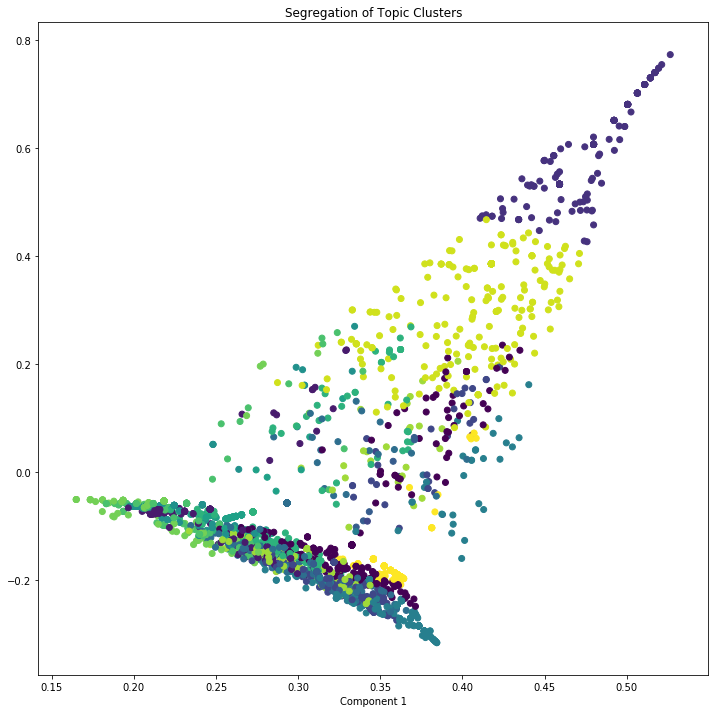

In [58]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )